In [1]:
import glob,os
import numpy as np
import pandas as pd
import scipy.signal as sg
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import h5py
import time as t 
from scipy.interpolate import make_smoothing_spline
from analysis_tools import *
from H5Dataframe import H5Dataframe

# Checks

## Comparison on platform model

In [ ]:
h5file = r'.\_ResultsH5\DecayMulti\decay_tests_SERAG.h5'
dynamic_keys = {
                'platform//Global total position//XGtranslationTotalmotion':'Surge [m]',
                'platform//Global total position//YGtranslationTotalmotion':'Sway [m]',
                'platform//Global total position//ZGtranslationTotalmotion':'Heave [m]',
                'platform//Global total position//XLrotationTotalmotion':'Roll [deg]',
                'platform//Global total position//YLrotationTotalmotion':'Pitch [deg]',
                'platform//Global total position//ZGrotationTotalmotion':'Yaw [deg]',
                'Origo/Wave elevation/Totalwaveelevation':'Elevation [m]',
}
H1 = H5Dataframe(h5file,dynamic_keys, source="file")

T_trans = 900
H1_perm = H1.skip_transient(T_trans)

In [ ]:
def error(x1, x2):
    return round(100 * np.linalg.norm(x1 - x2)/np.linalg.norm(x2),2)

def errorBRF(x_B, x_R, x_F):
    print('Error between Baseline and Rigid : ', error(x_B,x_R)) #round(100 * np.sqrt(np.mean((x_B - x_R)**2))/np.sqrt(np.mean(x_B**2)),2), ' %')
    # print('Error between Baseline and Flexible : ', error(x_B,x_F)) #round(100 * np.sqrt(np.mean((x_B - x_F)**2))/np.sqrt(np.mean(x_B**2)), 2), ' %')
    print('Error between Rigid and Flexible : ', error(x_F,x_R)) #round(100 * np.sqrt(np.mean((x_R - x_F)**2))/np.sqrt(np.mean(x_B**2)), 2), ' %')
    print('-----------------------------------')

### Time serie analysis

In [ ]:
outputs = ['Surge [m]', 'Pitch [deg]', 'Yaw [deg]']
conds = H1_perm.df.coords['condition'].values
fig,ax = plt.subplots(len(conds),len(outputs), figsize=(15, 25), dpi=600)

for i, cond in enumerate(conds):
    for j,output in enumerate(outputs):
        H1.comparePlot_timeseries(ax[i,j],'model',{'condition':cond, 'analysis':'Dynamic'},output)
        ax[i,j].set_title('Condition : ' + cond)
        # errorBRF(*timeseries)


fig.tight_layout()



## Comparison on wind model

In [ ]:
dynamic_keys = {
                'platform//Global total position//XGtranslationTotalmotion':'Surge [m]',
                'platform//Global total position//YGtranslationTotalmotion':'Sway [m]',
                'platform//Global total position//ZGtranslationTotalmotion':'Heave [m]',
                'platform//Global total position//XLrotationTotalmotion':'Roll [deg]',
                'platform//Global total position//YLrotationTotalmotion':'Pitch [deg]',
                'platform//Global total position//ZGrotationTotalmotion':'Yaw [deg]',
                'Origo/Wave elevation/Totalwaveelevation':'Elevation [m]',
}

h5_file_constwind = r'.\_ResultsH5\resOptiflexV0\Baseline_ConstWind_Results.h5'
h5_file_kaimal = r'.\_ResultsH5\resOptiflexV0\Baseline_KaimalTurbulence_Results.h5'
h5_file_mann = r'.\_ResultsH5\resOptiflexV0\Baseline_MannTurbulence_Results.h5'

H1 = H5Dataframe(h5_file_constwind,dynamic_keys, source="file")
H2 = H5Dataframe(h5_file_kaimal,dynamic_keys, source="file")
H3 = H5Dataframe(h5_file_mann,dynamic_keys, source="file")

H1.merge([H2,H3])


T_trans = 900
H1_perm = H1.skip_transient(T_trans)



# Analysis

### Load everything

In [2]:
load_list = [
    r'.\_ResultsH5\Baseline_\Baseline_ConstWind_Results.h5',
r'.\_ResultsH5\Baseline_\Baseline_KaimalTurbulence_Results.h5',
r'.\_ResultsH5\Baseline_\Baseline_MannTurbulence_Results.h5',
r'.\_ResultsH5\Flexible_\FlexibleC1P5_ConstWind_Results.h5',
r'.\_ResultsH5\Flexible_\FlexibleC1P5_KaimalTurbulence_Results.h5',
r'.\_ResultsH5\Flexible_\FlexibleC1P5_MannTurbulence_Results.h5'
]

dynamic_keys = {
                'platform//Global total position//XGtranslationTotalmotion':'Surge [m]',
                'platform//Global total position//YGtranslationTotalmotion':'Sway [m]',
                'platform//Global total position//ZGtranslationTotalmotion':'Heave [m]',
                'platform//Global total position//XLrotationTotalmotion':'Roll [deg]',
                'platform//Global total position//YLrotationTotalmotion':'Pitch [deg]',
                'platform//Global total position//ZGrotationTotalmotion':'Yaw [deg]',
                'line1//segment_1//node_1//Displacement in x - direction':'Xfairlead1 [m]',
                'line1//segment_1//node_1//Displacement in y - direction':'Yfairlead1 [m]',
                'line1//segment_1//node_1//Displacement in z - direction':'Zfairlead1 [m]',
                'Origo/Wave elevation/Totalwaveelevation':'Elevation [m]',
                'nacelle/Wind velocity/Velocityinmaindirection':'WindVelocity [m/s]',
                'turbine/Rotor speed (rpm)':'RotorSpeed [rpm]',
                'tower//segment_1//element_1//Mom_ about local y-axis, end 1':'ForeAftBendingMoment [kNm]',
                # 'turbine/Incoming wind speed X-dir in shaft system':'WindVelocity [m/s]',
                'line1//segment_1//element_1//Axial force':'TensionTopChainL1 [kN]',
                'line1//segment_2//element_1//Axial force':'TensionTopRopeL1 [kN]',
                'line1//segment_3//element_1//Axial force':'TensionBottomRopeL1 [kN]',
                'line1//segment_4//element_1//Axial force':'TensionBottomChainL1 [kN]',
                'line2//segment_1//element_1//Axial force':'TensionTopChainL2 [kN]',
                'line2//segment_2//element_1//Axial force':'TensionTopRopeL2 [kN]',
                'line2//segment_3//element_1//Axial force':'TensionBottomRopeL2 [kN]',
                'line2//segment_4//element_1//Axial force':'TensionBottomChainL2 [kN]',
                'line3//segment_1//element_1//Axial force':'TensionTopChainL3 [kN]',
                'line3//segment_2//element_1//Axial force':'TensionTopRopeL3 [kN]',
                'line3//segment_3//element_1//Axial force':'TensionBottomRopeL3 [kN]',
                'line3//segment_4//element_1//Axial force':'TensionBottomChainL3 [kN]',
                }

H1 = H5Dataframe(load_list[0],dynamic_keys, source="file")

H1.merge([H5Dataframe(load_list[i],dynamic_keys, source="file") for i in range(1,len(load_list))])

T_trans = 900
H1_perm = H1.skip_transient(T_trans)

No  Surge [m]  found for condition  ConstantWindSet_1 on model  INO_OptiFLEX22MW_Baseline
No  Sway [m]  found for condition  ConstantWindSet_1 on model  INO_OptiFLEX22MW_Baseline
No  Heave [m]  found for condition  ConstantWindSet_1 on model  INO_OptiFLEX22MW_Baseline
No  Roll [deg]  found for condition  ConstantWindSet_1 on model  INO_OptiFLEX22MW_Baseline
No  Pitch [deg]  found for condition  ConstantWindSet_1 on model  INO_OptiFLEX22MW_Baseline
No  Yaw [deg]  found for condition  ConstantWindSet_1 on model  INO_OptiFLEX22MW_Baseline
No  Xfairlead1 [m]  found for condition  ConstantWindSet_1 on model  INO_OptiFLEX22MW_Baseline
No  Yfairlead1 [m]  found for condition  ConstantWindSet_1 on model  INO_OptiFLEX22MW_Baseline
No  Zfairlead1 [m]  found for condition  ConstantWindSet_1 on model  INO_OptiFLEX22MW_Baseline
No  Elevation [m]  found for condition  ConstantWindSet_1 on model  INO_OptiFLEX22MW_Baseline
No  WindVelocity [m/s]  found for condition  ConstantWindSet_1 on model  INO_Op

## Checks

### Turbulent wind

#### Timeseries of the turbulent wind

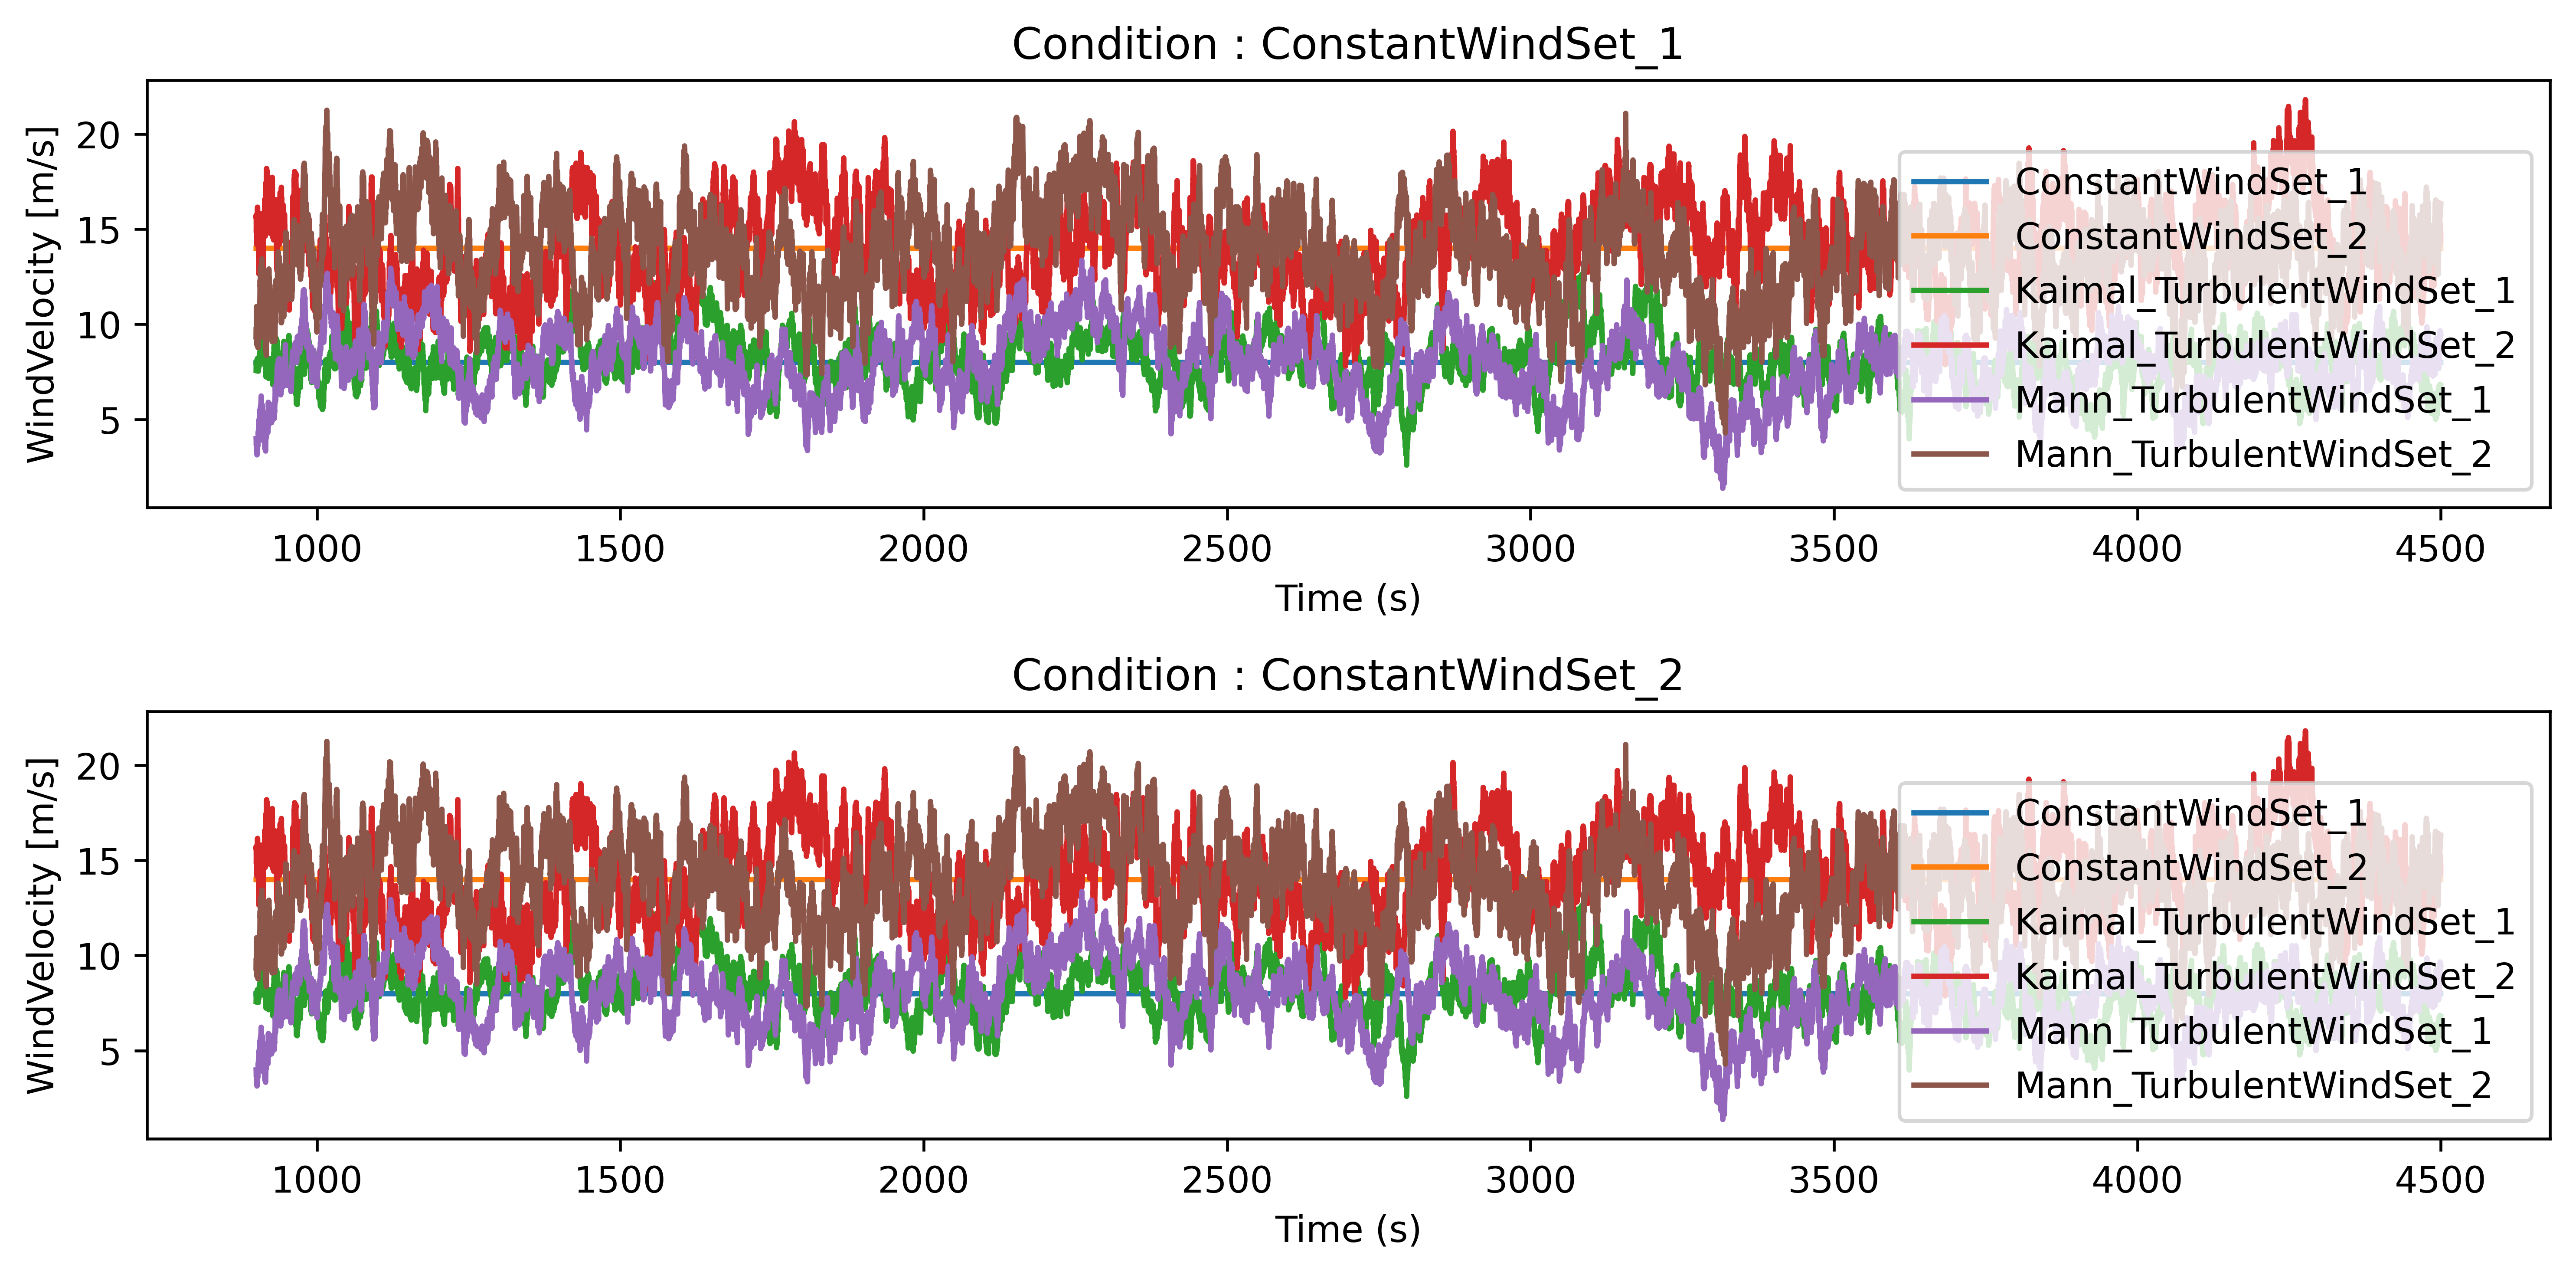

In [ ]:
outputs = ['WindVelocity [m/s]']
conds = H1_perm.df.coords['condition'].values[:2]
fig,ax = plt.subplots(len(conds),len(outputs), figsize=(len(conds)*5, len(outputs)*5), dpi=600)

for i, cond in enumerate(conds):
    for j,output in enumerate(outputs):
        # H_sel = H1_perm.selection(dict(condition = ['Kaimal_TurbulentWindSet_1', 'Kaimal_TurbulentWindSet_2']))
        H1_perm.comparePlot_timeseries(ax[i],'condition',{'model':'INO_OptiFLEX22MW_Flexible_C1P5', 'analysis':'Dynamic'},output)
        # H_sel.comparePlot_timeseries(ax[i],'model',{'condition':'Kaimal_TurbulentWindSet_1', 'analysis':'Dynamic'},output)
        ax[i].set_title('Condition : ' + cond)
        # errorBRF(*timeseries)


fig.tight_layout()

#### Mean and standard deviation of Uhub

In [ ]:
outputs = ['WindVelocity [m/s]', 'RotorSpeed [rpm]']
conds = H1_perm.df.coords['condition'].values#[:2]
fig,ax = plt.subplots(2,2, figsize=(12, 8), dpi=600)

l = "IEC standard"
expected_sigmaU = lambda u : 0.14*(0.75*u + 5.6) # From IEC 61400-1:2019
winds = np.array([8,14])

for i, cond in enumerate(conds):
    for j, output in enumerate(outputs):
        run = H1_perm.extract_run({'model':'INO_OptiFLEX22MW_Flexible_C1P5', 'analysis':'Dynamic', 'condition':cond})
#         ax[0].plot(Uhub, np.mean(x), label=set, color=colors[set],marker='.')
#         ax[1].plot(Uhub, np.std(x), label=set, color=colors[set],marker='.')
#         print('------------------')
#     ax[0].set_xlabel('Wind Speed (m/s)')
#     ax[0].set_ylabel('Mean Uhub')
#     ax[0].set_xlim(7,20)
#     ax[0].set_ylim(7,20)
#     ax[1].set_xlabel('Wind Speed (m/s)')
#     ax[1].set_ylabel('Sigma Uhub')
#     ax[1].set_xlim(7,20)
#     ax[1].set_ylim(1,3.5)
# ax[0].plot(winds,winds, label = l, color = 'green')
# ax[1].plot(winds,expected_sigmaU(winds), label = l, color = 'green')
# plt.legend(list(sets.keys()) + [l], ncol = 2, bbox_to_anchor=(0.5, 1.2))

#### Mean and standard deviation of rotor speed

In [ ]:
T_trans = 900 # seconds to skip as transient
conds = results_dict_kaimal_B.keys()
outputs = ['RotorSpeed [rpm]']
fig,ax = plt.subplots(1,len(conds), figsize=(12, 4), dpi=600)
# outputs = ['TensionTopChainL1 [kN]', 'TensionTopRopeL1 [kN]', 'TensionBottomRopeL1 [kN]', 'TensionBottomChainL1 [kN]']
sets = {'ConstantWindSet':results_dict_constwind_B, 'Kaimal_TurbulentWindSet':results_dict_kaimal_B, 'Mann_TurbulentWindSet':results_dict_mann_B}
colors = {'ConstantWindSet':'black', 'Kaimal_TurbulentWindSet':'blue', 'Mann_TurbulentWindSet':'red'}


for i, cond in enumerate(conds):
    Uhub = results_dict_kaimal_B[cond]['Variables']['Uhub']
    Hs = results_dict_kaimal_B[cond]['Variables']['Hs']
    Tp = results_dict_kaimal_B[cond]['Variables']['Tp']
    print('---'+str(i)+'---')
    for j, output in enumerate(outputs):
        for set in sets.keys():
            t = sets[set][set + '_' + str(i+1)]['Dynamic'][output + '_time']
            x = sets[set][set + '_' + str(i+1)]['Dynamic'][output]
            ax[0].plot(Uhub, np.mean(x), label=set, color=colors[set],marker='.')
            ax[1].plot(Uhub, np.std(x), label=set, color=colors[set],marker='.')
            # print('STD of set :' , set, np.std(x))
            print('timeStep of stored data : ', t[1]-t[0])
        print('------------------')
    ax[0].set_xlabel('Wind Speed (m/s)')
    ax[0].set_ylabel('Mean omega [rpm]')
    ax[0].set_xlim(7,20)
    # ax[0].set_ylim(7,20)
    ax[1].set_xlabel('Wind Speed (m/s)')
    ax[1].set_ylabel('Sigma omega [rpm]')
    ax[1].set_xlim(7,20)
    # ax[1].set_ylim(1,3.5)

plt.legend(list(sets.keys()), ncol = 2, bbox_to_anchor=(0.5, 1.2))

### Waves comparison

##### Timeseries

In [ ]:
T_trans = 900 # seconds to skip as transient
conds = results_dict_kaimal_B.keys()
outputs = ['Elevation [m]']
# outputs = ['TensionTopChainL1 [kN]', 'TensionTopRopeL1 [kN]', 'TensionBottomRopeL1 [kN]', 'TensionBottomChainL1 [kN]']
fig,ax = plt.subplots(len(conds),len(outputs), figsize=(16, 7), dpi=600)
sets = {'ConstantWindSet':results_dict_constwind_B, 'Kaimal_TurbulentWindSet':results_dict_kaimal_B, 'Mann_TurbulentWindSet':results_dict_mann_B}
colors = {'ConstantWindSet':'black', 'Kaimal_TurbulentWindSet':'blue', 'Mann_TurbulentWindSet':'red'}
for i, cond in enumerate(conds):
    Uhub = results_dict_kaimal_B[cond]['Variables']['Uhub']
    Hs = results_dict_kaimal_B[cond]['Variables']['Hs']
    Tp = results_dict_kaimal_B[cond]['Variables']['Tp']
    print('---'+str(i)+'---')
    plt.sca(ax[i])
    for j, output in enumerate(outputs):
        for set in sets.keys():
            t = sets[set][set + '_' + str(i+1)]['Dynamic'][output + '_time']
            x = sets[set][set + '_' + str(i+1)]['Dynamic'][output]
            t_perm = t[t>=T_trans]
            x_perm = x[t>=T_trans]
            dt = t_perm[1]-t_perm[0]
            plt.plot(t_perm, x_perm, label=set, color=colors[set], ls ='-')
            print('timeStep of stored data : ', dt)
        plt.xlabel('Time (s)')
        plt.ylabel(output)
        plt.grid()
        plt.title(f'Uhub={Uhub:.2f} m/s, Hs={Hs:.2f} m, Tp={Tp:.2f} s')
    fig.legend(list(sets.keys()), loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.05))
    fig.tight_layout()

##### Spectral checking

In [ ]:
T_trans = 900 # seconds to skip as transient
conds = results_dict_kaimal_B.keys()
outputs = ['Elevation [m]']
# outputs = ['TensionTopChainL1 [kN]', 'TensionTopRopeL1 [kN]', 'TensionBottomRopeL1 [kN]', 'TensionBottomChainL1 [kN]']
fig,ax = plt.subplots(1,len(conds), figsize=(16, 5), dpi=600)
sets = {'ConstantWindSet':results_dict_constwind_B, 'Kaimal_TurbulentWindSet':results_dict_kaimal_B, 'Mann_TurbulentWindSet':results_dict_mann_B}
colors = {'ConstantWindSet':'black', 'Kaimal_TurbulentWindSet':'blue', 'Mann_TurbulentWindSet':'red'}
for i, cond in enumerate(conds):
    Uhub = results_dict_kaimal_B[cond]['Variables']['Uhub']
    Hs = results_dict_kaimal_B[cond]['Variables']['Hs']
    Tp = results_dict_kaimal_B[cond]['Variables']['Tp']
    print('---'+str(i)+'---')
    plt.sca(ax[i])
    for j, output in enumerate(outputs):
        for set in sets.keys():
            t = sets[set][set + '_' + str(i+1)]['Dynamic'][output + '_time']
            x = sets[set][set + '_' + str(i+1)]['Dynamic'][output]
            t_perm = t[t>=T_trans]
            x_perm = x[t>=T_trans]
            dt = t_perm[1]-t_perm[0]
            freq, Sp = PSD_wave4(x_perm, dt)
            Sp /= 2*np.pi
            plt.scatter(freq, Sp, label=set, color=colors[set], marker='.')
            plt.xlim(0.01, 0.3)
            plt.ylim(0, 4)
            print('timeStep of stored data : ', dt)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel(output)
        plt.grid()
        plt.title(f'Uhub={Uhub:.2f} m/s, Hs={Hs:.2f} m, Tp={Tp:.2f} s')
    f_jons = np.linspace(0.01, 1., 1000)
    Sp_jons = jonswap(f_jons,Hs,Tp)
    plt.plot(f_jons, Sp_jons, label = "Jonswap for C"+str(i), color = 'green')
fig.legend(list(sets.keys()) + ["Jonswap"], ncol=2, bbox_to_anchor=(0.6, 1.1))
fig.tight_layout()

### Consistence with litterature

In [ ]:
T_trans = 900 # seconds to skip as transient
conds = results_dict_kaimal_B.keys()
outputs = ['Surge [m]', 'Pitch [deg]', 'Yaw [deg]']
fig,ax = plt.subplots(len(outputs),3, figsize=(12,10), dpi=600)
# outputs = ['TensionTopChainL1 [kN]', 'TensionTopRopeL1 [kN]', 'TensionBottomRopeL1 [kN]', 'TensionBottomChainL1 [kN]']
sets = {'ConstantWindSet':results_dict_constwind_B, 'Kaimal_TurbulentWindSet':results_dict_kaimal_B, 'Mann_TurbulentWindSet':results_dict_mann_B}
colors = {'ConstantWindSet':'black', 'Kaimal_TurbulentWindSet':'blue', 'Mann_TurbulentWindSet':'red'}

# Results from Bachynski / Eliasen
surge5MW = [
    {'Kaimal_TurbulentWindSet':1.3, 'Mann_TurbulentWindSet':1.1},
    {'Kaimal_TurbulentWindSet':1.3, 'Mann_TurbulentWindSet':1.25}
]
pitch5MW = [
    {'Kaimal_TurbulentWindSet':1.2, 'Mann_TurbulentWindSet':1},
    {'Kaimal_TurbulentWindSet':2.7, 'Mann_TurbulentWindSet':2.55}
]
yaw5MW = [
    {'Kaimal_TurbulentWindSet':0.45, 'Mann_TurbulentWindSet':0.6},
    {'Kaimal_TurbulentWindSet':0.65, 'Mann_TurbulentWindSet':0.9}
]
surge10MW = [
    {'Kaimal_TurbulentWindSet':2.1, 'Mann_TurbulentWindSet':1.75},
    {'Kaimal_TurbulentWindSet':2, 'Mann_TurbulentWindSet':1.9}
]
pitch10MW = [
    {'Kaimal_TurbulentWindSet':1.1, 'Mann_TurbulentWindSet':0.9},
    {'Kaimal_TurbulentWindSet':2.3, 'Mann_TurbulentWindSet':2}
]
yaw10MW = [
    {'Kaimal_TurbulentWindSet':0.55, 'Mann_TurbulentWindSet':0.75},
    {'Kaimal_TurbulentWindSet':1, 'Mann_TurbulentWindSet':1.3}
]
litterature = {
    'Surge [m]': [surge5MW, surge10MW], 
    'Pitch [deg]': [pitch5MW, pitch10MW],
    'Yaw [deg]': [yaw5MW, yaw10MW],
}

for i, cond in enumerate(conds):
    Uhub = results_dict_kaimal_B[cond]['Variables']['Uhub']
    Hs = results_dict_kaimal_B[cond]['Variables']['Hs']
    Tp = results_dict_kaimal_B[cond]['Variables']['Tp']
    print('---'+str(i)+'---')
    for j, output in enumerate(outputs):
        for set in sets.keys():
            if set in ['Kaimal_TurbulentWindSet', 'Mann_TurbulentWindSet']:
                t = sets[set][set + '_' + str(i+1)]['Dynamic'][output + '_time']
                x = sets[set][set + '_' + str(i+1)]['Dynamic'][output]
                t_perm = t[t>=T_trans]
                x_perm = x[t>=T_trans]
                x_filt = bw_filter(x_perm, cutoff=1/15, fs=1/dt, order=2, switch='high') + x_perm.mean()

                dt = t_perm[1]-t_perm[0]

                ax[0,j].plot(Uhub, np.mean(x_perm), label=set, color=colors[set],marker='.')
                ax[1,j].plot(Uhub, np.std(x_perm), label=set, color=colors[set],marker='.')
                ax[2,j].plot(Uhub, np.std(x_filt), label=set, color=colors[set],marker='.')

                ref = litterature[output]
                label = set[:-16]
                ax[1,j].plot(Uhub, ref[0][i][set], label='ref5MW '+ label,color=colors[set],marker='x')
                ax[1,j].plot(Uhub, ref[1][i][set], label='ref10MW '+ label,color=colors[set],marker='+')
                # ax[2,j].plot(Uhub, ref[0][i][set], label='ref5MW '+ label, color=colors[set],marker='x')
                # ax[2,j].plot(Uhub, ref[1][i][set], label='ref10MW '+ label, color=colors[set],marker='x')

                print('timeStep of stored data : ', dt)

        ax[0,j].set_xlabel('Wind Speed (m/s)')
        ax[0,j].set_ylabel('Mean of ' + output)
        ax[1,j].set_xlabel('Wind Speed (m/s)')
        ax[1,j].set_ylabel('Std of ' + output)
        ax[2,j].set_xlabel('Wind Speed (m/s)')
        ax[2,j].set_ylabel('Std of filtered ' + output)
        print('------------------')

fig.legend(['Kaimal_TurbulentWindSet','ref5MWKaimal',  'ref10MWKaimal', 'Mann_TurbulentWindSet', 'ref5MWMann', 'ref10MWMann'], ncol = 2, loc = "upper center", bbox_to_anchor=(0.5, 1.1))
fig.tight_layout()

### Filtered timeserie analysis

In [ ]:
T_trans = 900 # seconds to skip as transient
conds = results_dict_kaimal_B.keys()
outputs = ['Surge [m]', 'Yaw [deg]', 'Pitch [deg]', 'Roll [deg]']
# outputs = ['TensionTopChainL1 [kN]', 'TensionTopRopeL1 [kN]', 'TensionBottomRopeL1 [kN]', 'TensionBottomChainL1 [kN]']
sets = {'ConstantWindSet':results_dict_constwind_B, 'Kaimal_TurbulentWindSet':results_dict_kaimal_B, 'Mann_TurbulentWindSet':results_dict_mann_B}
colors = {'ConstantWindSet':'black', 'Kaimal_TurbulentWindSet':'blue', 'Mann_TurbulentWindSet':'red'}

fig,ax = plt.subplots(len(conds),len(outputs), figsize=(16, 10), dpi=600)
fig2,ax2 = plt.subplots(len(conds),len(outputs), figsize=(16, 10), dpi=600)

for i, cond in enumerate(conds):
    Uhub = results_dict_kaimal_B[cond]['Variables']['Uhub']
    Hs = results_dict_kaimal_B[cond]['Variables']['Hs']
    Tp = results_dict_kaimal_B[cond]['Variables']['Tp']
    print('---'+str(i)+'---')
    for j, output in enumerate(outputs):
        for set in sets.keys():
            t = sets[set][set + '_' + str(i+1)]['Dynamic'][output + '_time']
            x = sets[set][set + '_' + str(i+1)]['Dynamic'][output]
            t_perm = t[t>=T_trans]
            x_perm = x[t>=T_trans]
            dt = t_perm[1]-t_perm[0]
            
            x_filt = bw_filter(x_perm, cutoff=1/15, fs=1/dt, order=2, switch='high') + x_perm.mean()

            plt.sca(ax[i,j])
            plt.plot(t_perm, x_perm, '--r', label='SIMA')
            plt.plot(t_perm, x_filt, ':b', label='SIMA (HP filtered)')
            plt.xlabel('Time (s)')
            plt.ylabel(output)
            plt.grid()

            plt.sca(ax2[i,j])
            plt.plot(t_perm, x_perm-x_perm.mean(), '--r', label='SIMA')
            plt.plot(t_perm, x_filt-x_filt.mean(), ':b', label='SIMA (HP filtered)')
            plt.xlabel('Time (s)')
            plt.ylabel(output + ' (deviation from mean)')
            plt.grid()

fig.legend(['RAW', 'FILTERED'], loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.05))
fig.tight_layout()
fig2.legend(['RAW', 'FILTERED'], loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.05))
fig2.tight_layout()

## Mooring loads

### Frequency analysis

#### Fourier transform of Line 1

In [ ]:
T_trans = 900 # seconds to skip as transient
conds = results_dict_kaimal_B.keys()
# outputs = ['Surge [m]', 'Yaw [deg]', 'Pitch [deg]','Heave [m]']
outputs = ['TensionTopChainL1 [kN]', 'TensionTopRopeL1 [kN]', 'TensionBottomRopeL1 [kN]', 'TensionBottomChainL1 [kN]']
sets = [
    {'ConstantWindSet':results_dict_constwind_B, 'Kaimal_TurbulentWindSet':results_dict_kaimal_B, 'Mann_TurbulentWindSet':results_dict_mann_B},
    {'ConstantWindSet':results_dict_constwind_F, 'Kaimal_TurbulentWindSet':results_dict_kaimal_F, 'Mann_TurbulentWindSet':results_dict_mann_F}
]
colors = [
    {'ConstantWindSet':'black', 'Kaimal_TurbulentWindSet':'blue', 'Mann_TurbulentWindSet':'red'},
    {'ConstantWindSet':'black', 'Kaimal_TurbulentWindSet':'blue', 'Mann_TurbulentWindSet':'red'}
]


# for i,cond in enumerate(conds):
#     Uhub = results_dict_kaimal_B[cond]['Variables']['Uhub']
#     Hs = results_dict_kaimal_B[cond]['Variables']['Hs']
#     Tp = results_dict_kaimal_B[cond]['Variables']['Tp']
#     for j, output in enumerate(outputs):
#         fig = go.Figure()
#         for set in sets.keys():
#             t = sets[set][set + '_' + str(i+1)]['Dynamic'][output + '_time']
#             x = sets[set][set + '_' + str(i+1)]['Dynamic'][output]
#             t_perm = t[t>=T_trans]
#             x_perm = x[t>=T_trans]
#             x_fft = np.fft.fft(x_perm)
#             freq = np.fft.fftfreq(len(t_perm), d=t_perm[1]-t_perm[0])
#             # Only plot positive frequencies
#             mask = freq > 0
#             fig.add_trace(go.Scatter(
#                 x=freq[mask],
#                 y=np.abs(x_fft[mask]),
#                 mode='lines+markers',
#                 name=set,
#                 line=dict(color=colors[set])
#             ))
#         fig.update_layout(
#             title=f'{output} | Uhub = {Uhub} m/s, Hs = {Hs} m, Tp = {Tp} s',
#             xaxis_title='Frequency (Hz)',
#             yaxis_title=output,
#             xaxis=dict(range=[0, 0.3]),
#             legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='center', x=0.5)
#         )
#         fig.show()

fig,ax = plt.subplots(len(conds),len(outputs), figsize=(16, 7), dpi=600)
for i, cond in enumerate(conds):
    Uhub = results_dict_kaimal_B[cond]['Variables']['Uhub']
    Hs = results_dict_kaimal_B[cond]['Variables']['Hs']
    Tp = results_dict_kaimal_B[cond]['Variables']['Tp']
    for j, output in enumerate(outputs):
        plt.sca(ax[i,j])
        for set in sets[0].keys():  
            for i_plat in range(2):   
                t = sets[i_plat][set][set + '_' + str(i+1)]['Dynamic'][output + '_time']
                x = sets[i_plat][set][set + '_' + str(i+1)]['Dynamic'][output]
                t_perm = t[t>=T_trans]
                x_perm = x[t>=T_trans]
                dt = t_perm[1]-t_perm[0]
                
                # x_perm = bw_filter(x_perm, cutoff=4, fs=1/dt, order=2, switch='low') + x_perm.mean()
                freq, x_fft = FFT(x_perm, dt)
                x_fft = bw_filter(x_fft, cutoff=1/dt, fs=1/(freq[1]), order=2, switch='low')

                lab = set + '_B'*(i_plat==0) + '_F'*(i_plat==1)
                ls = '-'*(i_plat==0) + ':'*(i_plat==1)
                plt.semilogy(freq, abs(x_fft), label=lab, color=colors[i_plat][set], ls=ls)
                plt.xlim(0, 1.) # some window
                # plt.ylim(0,1e3)
        print('timeStep of stored data : ', dt)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel(output)
        plt.grid()
        plt.title(f'Uhub={Uhub:.2f} m/s, Hs={Hs:.2f} m, Tp={Tp:.2f} s')

# fig.suptitle('Baseline')
fig.legend(['ConstantWindSet_B','ConstantWindSet_F', 'Kaimal_TurbulentWindSet_B', 'Kaimal_TurbulentWindSet_F', 'Mann_TurbulentWindSet_B','Mann_TurbulentWindSet_F'], loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.1))
fig.tight_layout()

#### Fourier transform all lines

In [ ]:
T_trans = 900 # seconds to skip as transient
conds = results_dict_kaimal_B.keys()

i_plat = 0


outputs = [
    ['TensionTopChainL1 [kN]', 'TensionTopRopeL1 [kN]', 'TensionBottomRopeL1 [kN]', 'TensionBottomChainL1 [kN]'],
    ['TensionTopChainL2 [kN]', 'TensionTopRopeL2 [kN]', 'TensionBottomRopeL2 [kN]', 'TensionBottomChainL2 [kN]'],
    ['TensionTopChainL3 [kN]', 'TensionTopRopeL3 [kN]', 'TensionBottomRopeL3 [kN]', 'TensionBottomChainL3 [kN]']
]

sets = [
    {'ConstantWindSet':results_dict_constwind_B, 'Kaimal_TurbulentWindSet':results_dict_kaimal_B, 'Mann_TurbulentWindSet':results_dict_mann_B},
    {'ConstantWindSet':results_dict_constwind_F, 'Kaimal_TurbulentWindSet':results_dict_kaimal_F, 'Mann_TurbulentWindSet':results_dict_mann_F}
]
colors = [
    {'ConstantWindSet':'black', 'Kaimal_TurbulentWindSet':'blue', 'Mann_TurbulentWindSet':'red'},
    {'ConstantWindSet':'black', 'Kaimal_TurbulentWindSet':'blue', 'Mann_TurbulentWindSet':'red'}
]
ls = {
    0:'-',
    1:':',
    2:'--'
}

fig,ax = plt.subplots(len(conds),len(outputs[0]), figsize=(16, 7), dpi=600)


for i, cond in enumerate(conds):
    Uhub = results_dict_kaimal_B[cond]['Variables']['Uhub']
    Hs = results_dict_kaimal_B[cond]['Variables']['Hs']
    Tp = results_dict_kaimal_B[cond]['Variables']['Tp']
    for k in range(len(outputs)-1):
        for j, output in enumerate(outputs[k]):
            plt.sca(ax[i,j])
            for set in sets[0].keys():  
                
                t = sets[i_plat][set][set + '_' + str(i+1)]['Dynamic'][output + '_time']
                x = sets[i_plat][set][set + '_' + str(i+1)]['Dynamic'][output]
                t_perm = t[t>=T_trans]
                x_perm = x[t>=T_trans]
                dt = t_perm[1]-t_perm[0]
                
                # x_perm = bw_filter(x_perm, cutoff=4, fs=1/dt, order=2, switch='low') + x_perm.mean()
                freq, x_fft = FFT(x_perm, dt)
                x_fft = bw_filter(x_fft, cutoff=1/dt, fs=1/(freq[1]), order=2, switch='low')

                plt.semilogy(freq, abs(x_fft), label=output, color=colors[i_plat][set], ls=ls[k])
                plt.xlim(0.01, 1.) # some window
                # plt.ylim(0,1e3)
            print('timeStep of stored data : ', dt)
            plt.xlabel('Frequency (Hz)')
            plt.ylabel(output[:-7])
            plt.grid()
            plt.title(f'Uhub={Uhub:.2f} m/s, Hs={Hs:.2f} m, Tp={Tp:.2f} s')

# fig.suptitle('Baseline')
fig.legend(list(sets[0].keys()), loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.1))
fig.tight_layout()

#### Spectral analysis

In [ ]:
percentagePSD = True
label_perc = '' + percentagePSD * '% '

n_plat = 2
T_trans = 900 # seconds to skip as transient


conds = results_dict_kaimal_B.keys()
# outputs = ['Elevation [m]']
outputs = ['TensionTopChainL1 [kN]', 'TensionTopRopeL1 [kN]', 'TensionBottomRopeL1 [kN]', 'TensionBottomChainL1 [kN]']
outputs2 = ['Surge [m]', 'Pitch [deg]', 'Yaw [deg]', 'ForeAftBendingMoment [kNm]']
fig,ax = plt.subplots(len(conds),len(outputs), figsize=(16, 6), dpi=600)
fig2,ax2 = plt.subplots(len(conds),len(outputs2), figsize=(16, 6), dpi=600)
sets = [
    {'ConstantWindSet':results_dict_constwind_B, 'Kaimal_TurbulentWindSet':results_dict_kaimal_B, 'Mann_TurbulentWindSet':results_dict_mann_B},
    {'ConstantWindSet':results_dict_constwind_F, 'Kaimal_TurbulentWindSet':results_dict_kaimal_F, 'Mann_TurbulentWindSet':results_dict_mann_F}
]
colors = [
    {'ConstantWindSet':'black', 'Kaimal_TurbulentWindSet':'blue', 'Mann_TurbulentWindSet':'red'},
    {'ConstantWindSet':'grey', 'Kaimal_TurbulentWindSet':'cyan', 'Mann_TurbulentWindSet':'orange'}
]

for i, cond in enumerate(conds):

    Uhub = results_dict_kaimal_B[cond]['Variables']['Uhub']
    Hs = results_dict_kaimal_B[cond]['Variables']['Hs']
    Tp = results_dict_kaimal_B[cond]['Variables']['Tp']
    print('---'+str(i)+'---')

    for j, output in enumerate(outputs):
        plt.sca(ax[i,j])

        for set in sets[0].keys():  
            for i_plat in range(n_plat):   
                t = sets[i_plat][set][set + '_' + str(i+1)]['Dynamic'][output + '_time']
                x = sets[i_plat][set][set + '_' + str(i+1)]['Dynamic'][output]
                t_perm = t[t>=T_trans]
                x_perm = x[t>=T_trans]
                dt = t_perm[1]-t_perm[0]
                
                freq, Sp = PSD_wave4(x_perm, dt) # sg.welch(x_perm, 1/dt, nperseg=int(len(x_perm)/4))
                Sp *= (100/np.sum(Sp))**percentagePSD

                lab = set + '_B'*(i_plat==0) + '_F'*(i_plat==1)
                ls = '-'*(i_plat==0) + '-'*(i_plat==1)
                plt.semilogy(freq, Sp, label=lab, color=colors[i_plat][set], ls=ls)
                plt.xlim(0.01, 1.) # some window
                # plt.ylim(0,1e3)
        print('timeStep of stored data : ', dt)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel(label_perc +'PSD of ' + output)
        plt.grid()
        plt.title(f'Uhub={Uhub:.2f} m/s, Hs={Hs:.2f} m, Tp={Tp:.2f} s')
        
    for j, output in enumerate(outputs2):
        plt.sca(ax2[i,j])
        for set in sets[0].keys():
            for i_plat in range(n_plat):   
                t = sets[i_plat][set][set + '_' + str(i+1)]['Dynamic'][output + '_time']
                x = sets[i_plat][set][set + '_' + str(i+1)]['Dynamic'][output]
                t_perm = t[t>=T_trans]
                x_perm = x[t>=T_trans]
                dt = t_perm[1]-t_perm[0]
                
                freq, Sp = PSD_wave4(x_perm, dt) # sg.welch(x_perm, 1/dt, nperseg=int(len(x_perm)/4))
                Sp *= (100/np.sum(Sp))**percentagePSD

                lab = set + '_B'*(i_plat==0) + '_F'*(i_plat==1)
                ls = '-'*(i_plat==0) + '-'*(i_plat==1)
                plt.semilogy(freq, Sp, label=lab, color=colors[i_plat][set], ls=ls)
                plt.xlim(0.01, 1.) # some window
                # plt.ylim(0,1e3)
        print('timeStep of stored data : ', dt)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel(label_perc + 'PSD of ' + output)
        plt.grid()
        plt.title(f'Uhub={Uhub:.2f} m/s, Hs={Hs:.2f} m, Tp={Tp:.2f} s')
    
# fig.legend(list(sets.keys()), loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.05))
# fig.tight_layout()
# fig2.legend(list(sets.keys()), loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.05))
# fig2.tight_layout()
leg = []
if n_plat == 1:
    leg = ['ConstantWindSet_B','Kaimal_TurbulentWindSet_B', 'Mann_TurbulentWindSet_B']
elif n_plat == 2:
    leg = ['ConstantWindSet_B','ConstantWindSet_F', 'Kaimal_TurbulentWindSet_B', 'Kaimal_TurbulentWindSet_F', 'Mann_TurbulentWindSet_B','Mann_TurbulentWindSet_F']
# fig.suptitle('Baseline')
fig.legend(leg, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.1))
fig.tight_layout()
# fig.suptitle('Baseline')
fig2.legend(leg, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.1))
fig2.tight_layout()

### 90% max

In [ ]:
# T_trans = 900 # seconds to skip as transient
# conds = results_dict_constwind_B.keys()
# outputs = ['Surge [m]', 'Yaw [deg]', 'Pitch [deg]']
# fig,ax = plt.subplots(len(conds),len(outputs), figsize=(16, 7), dpi=600)
# sets = {'ConstantWindSet':results_dict_constwind_B, 'Kaimal_TurbulentWindSet':results_dict_kaimal_B, 'Mann_TurbulentWindSet':results_dict_mann_B}
# colors = {'ConstantWindSet':'black', 'Kaimal_TurbulentWindSet':'blue', 'Mann_TurbulentWindSet':'red'}
# for i, cond in enumerate(conds):
#     Uhub = results_dict_constwind_B[cond]['Variables']['Uhub']
#     Hs = results_dict_constwind_B[cond]['Variables']['Hs']
#     Tp = results_dict_constwind_B[cond]['Variables']['Tp']
#     for j, output in enumerate(outputs):
#         plt.sca(ax[i,j])
#         for set in sets.keys():
#             t = sets[set][set + '_' + str(i+1)]['Dynamic']['Time'].to_numpy()
#             x = sets[set][set + '_' + str(i+1)]['Dynamic'][output].to_numpy()
#             plt.plot(t[t>=T_trans], x[t>=T_trans], label=set, color=colors[set],ls='-')
#         plt.xlabel('Time (s)')
#         plt.ylabel(output)
#         plt.grid()
#         plt.title(f'Uhub={Uhub:.2f} m/s, Hs={Hs:.2f} m, Tp={Tp:.2f} s')
#     fig.legend(list(sets.keys()), loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.05))
#     fig.tight_layout()

## Platform comparisons

### Timeseries and usual DOFs